The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.0/95.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfull

# 多层感知机的从零开始实现
:label:`sec_mlp_scratch`

我们已经在 :numref:`sec_mlp`中描述了多层感知机（MLP），
现在让我们尝试自己实现一个多层感知机。
为了与之前softmax回归（ :numref:`sec_softmax_scratch` ）
获得的结果进行比较，
我们将继续使用Fashion-MNIST图像分类数据集
（ :numref:`sec_fashion_mnist`）。


In [11]:
import torch
from torch import nn
from IPython import display
from d2l import torch as d2l

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 266kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.00MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.3MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 初始化模型参数

回想一下，Fashion-MNIST中的每个图像由
$28 \times 28 = 784$个灰度像素值组成。
所有图像共分为10个类别。
忽略像素之间的空间结构，
我们可以将每个图像视为具有784个输入特征
和10个类的简单分类数据集。
首先，我们将[**实现一个具有单隐藏层的多层感知机，
它包含256个隐藏单元**]。
注意，我们可以将这两个变量都视为超参数。
通常，我们选择2的若干次幂作为层的宽度。
因为内存在硬件中的分配和寻址方式，这么做往往可以在计算上更高效。

我们用几个张量来表示我们的参数。
注意，对于每一层我们都要记录一个权重矩阵和一个偏置向量。
跟以前一样，我们要为损失关于这些参数的梯度分配内存。


In [3]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 激活函数

为了确保我们对模型的细节了如指掌，
我们将[**实现ReLU激活函数**]，
而不是直接调用内置的`relu`函数。


In [4]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

## 模型

因为我们忽略了空间结构，
所以我们使用`reshape`将每个二维图像转换为一个长度为`num_inputs`的向量。
只需几行代码就可以(**实现我们的模型**)。


In [5]:
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    return (H@W2 + b2)

## 损失函数

由于我们已经从零实现过softmax函数（ :numref:`sec_softmax_scratch`），
因此在这里我们直接使用高级API中的内置函数来计算softmax和交叉熵损失。
回想一下我们之前在 :numref:`subsec_softmax-implementation-revisited`中
对这些复杂问题的讨论。
我们鼓励感兴趣的读者查看损失函数的源代码，以加深对实现细节的了解。


In [6]:
loss = nn.CrossEntropyLoss(reduction='none')

## 训练

幸运的是，[**多层感知机的训练过程与softmax回归的训练过程完全相同**]。
可以直接调用`d2l`包的`train_ch3`函数（参见 :numref:`sec_softmax_scratch` ），
将迭代周期数设置为10，并将学习率设置为0.1.


In [8]:
#新d2l中没有train_ch3，直接用之前的源码
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

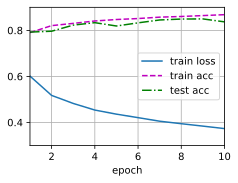

In [12]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

为了对学习到的模型进行评估，我们将[**在一些测试数据上应用这个模型**]。


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


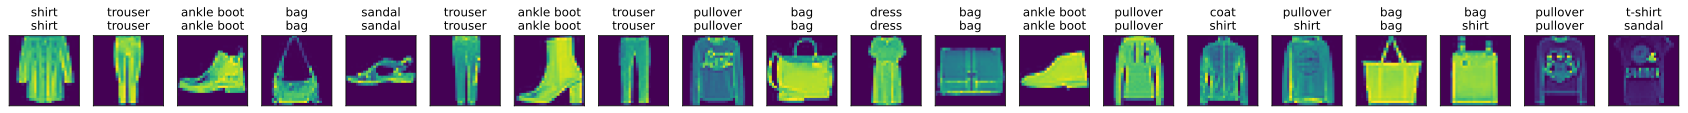

In [16]:
#d2l.predict_ch3(net, test_iter)

#预测
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）"""
    count = 0
    for X, y in test_iter:
        count = count + 1
        if count > 2:
          break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter, 20)

## 小结

* 手动实现一个简单的多层感知机是很容易的。然而如果有大量的层，从零开始实现多层感知机会变得很麻烦（例如，要命名和记录模型的参数）。

## 练习

1. 在所有其他参数保持不变的情况下，更改超参数`num_hiddens`的值，并查看此超参数的变化对结果有何影响。确定此超参数的最佳值。
1. 尝试添加更多的隐藏层，并查看它对结果有何影响。
1. 改变学习速率会如何影响结果？保持模型架构和其他超参数（包括轮数）不变，学习率设置为多少会带来最好的结果？
1. 通过对所有超参数（学习率、轮数、隐藏层数、每层的隐藏单元数）进行联合优化，可以得到的最佳结果是什么？
1. 描述为什么涉及多个超参数更具挑战性。
1. 如果想要构建多个超参数的搜索方法，请想出一个聪明的策略。


[Discussions](https://discuss.d2l.ai/t/1804)
